In [1]:
# базовые библиотеки (pandas, numpy, scipy, matplotlib)
import pandas as pd
import numpy as np
import re
from pprint import pprint
import string
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# анализатор морфологии и детектор языков
import pymorphy2
from langdetect import detect

# библиотека nltk (обработка естественных языков)
import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')

# библиотека scikit-learn (машинное обучение)
from sklearn import metrics 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# библиотека gensim (тематическое моделирование)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore

# библиотека для визуализации тем LDA
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# облако слов
from wordcloud import WordCloud

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
# взял первые 2000 доменов с текстов. выкинул NA
df = pd.read_excel('sample2.xlsx')
df.dropna(inplace=True)
df.head()

,Unnamed: 0,domain,text
1,1,parcedsites/mainpages/4e/82/fc/4e82fc971d8437c...,Холодильник.Ру - интернет-магазин бытовой...
3,3,parcedsites/mainpages/ef/dc/3d/efdc3d6ddb4d692...,308 Permanent Redirect 308 Permanent Redirec...
4,4,parcedsites/mainpages/53/56/1a/53561ad89c74b0f...,
5,5,parcedsites/mainpages/a4/1e/9c/a41e9c11f42834e...,
7,7,parcedsites/mainpages/32/23/67/322367b9334085b...,Best VPN service. Online security starts w...


In [21]:
# в датасете домены на разных языках. загрузил библиотеку langdetect чтобы определить язык.
# там где язык определить невозможно - выставил Not Detected
langs = []
for i in df['text']:
    try:
        l = detect(i)
        langs.append(l)
    except:
        langs.append('Not Detected')
    continue

In [22]:
# дропнул ряды в которых невозможно определить язык
df['language'] = langs
df = df[df['language'] != 'Not Detected']
df

,Unnamed: 0,domain,text,language
1,1,parcedsites/mainpages/4e/82/fc/4e82fc971d8437c...,Холодильник.Ру - интернет-магазин бытовой...,ru
3,3,parcedsites/mainpages/ef/dc/3d/efdc3d6ddb4d692...,308 Permanent Redirect 308 Permanent Redirec...,en
7,7,parcedsites/mainpages/32/23/67/322367b9334085b...,Best VPN service. Online security starts w...,en
8,8,parcedsites/mainpages/74/3e/f3/743ef358d902290...,Итальянская обувь и одежда в Украине – Инт...,ru
9,9,parcedsites/mainpages/31/a2/88/31a288bd9f2555e...,308 Permanent Redirect 308 Permanent Redirec...,en
...,...,...,...,...
1995,1995,parcedsites/mainpages/84/2c/5c/842c5c3e2d55c8b...,VivaTerra | Homepage ...,en
1996,1996,parcedsites/mainpages/9a/7e/41/9a7e4190913ae5b...,Welcome to ...,en
1997,1997,parcedsites/mainpages/ea/67/83/ea6783b6aa5eff0...,UK Hotels | Luxury Four Sta...,en
1998,1998,parcedsites/mainpages/5d/a7/b3/5da7b3076b91579...,ファッション通販サイトのSTRIPE CLUB（ストライプクラブ） ...,ja


In [23]:
# большая часть датасета на русском
df['language'].value_counts()

en    832
ru    730
de    100
uk     49
pl     43
ja     24
tr     16
pt     15
es     15
fr     14
ar     11
da      9
it      9
bg      7
id      6
et      5
ro      4
nl      4
ca      3
he      3
hu      2
hr      2
sw      1
sk      1
af      1
sv      1
cs      1
ko      1
sl      1
sq      1
Name: language, dtype: int64

In [24]:
# решил потестить на русскоязычных доменах
df_ru = df[df['language'] == 'ru']
df_ru

,Unnamed: 0,domain,text,language
1,1,parcedsites/mainpages/4e/82/fc/4e82fc971d8437c...,Холодильник.Ру - интернет-магазин бытовой...,ru
8,8,parcedsites/mainpages/74/3e/f3/743ef358d902290...,Итальянская обувь и одежда в Украине – Инт...,ru
10,10,parcedsites/mainpages/bd/26/82/bd2682cc0c753fe...,Бука ...,ru
18,18,parcedsites/mainpages/09/0b/32/090b3294c738725...,0Кредиты онлайн на карту за 10 минут без отказ...,ru
19,19,parcedsites/mainpages/63/81/09/638109147c5d950...,Официальный интернет-магазин New Balance в...,ru
...,...,...,...,...
1615,1615,parcedsites/mainpages/4a/87/9b/4a879b5271c6512...,"Недвижимость в Казахстане, продажа недвиж...",ru
1737,1737,parcedsites/mainpages/c8/52/fb/c852fb469bab514...,Kviku | Online Bank ...,ru
1758,1758,parcedsites/mainpages/4b/86/3e/4b863e63d946b48...,Neoline - Официальный интернет магазин авто...,ru
1891,1891,parcedsites/mainpages/86/32/72/863272a6dfadc58...,AliExpress - интернет-магазин электрони...,ru


In [25]:
# конверитируем данные в лист
data = df_ru['text'].values.tolist()

# очищаем от лишних символов
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]

# препроцессинг
morph = pymorphy2.MorphAnalyzer() # анализатор морфологии
stemmer = SnowballStemmer("russian") # русский стеммер
russian_stopwords = stopwords.words("russian") # русские стопворды
russian_stopwords.extend(['руб','год','продукт','магазин','аксессуар','товар','купить','оплата','набор','акция','кредит','карта','программа'])

# очищаем от пунктуации
def punct(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True убирает пунктацию

# лемматизация
def lemmatization(data):
    lemmatized = []
    for i in data:
        funсtion_words = {'INTJ', 'PRCL', 'CONJ', 'PREP'}
        i = list(map(lambda word: morph.parse(word)[0], i))
        result = []
        for word in i:
            if word.tag.POS not in funсtion_words:
                result.append(word.normal_form)
        lemmatized.append(result)
    return lemmatized
        
# убираем стоп-ворды
def stop_words_removal(data):
    data = [[word for word in simple_preprocess(str(doc)) if word not in russian_stopwords] for doc in data]
    return data
        
# стеммер
def stemming(data):
    stemmed = []
    for i in data:
        i = list(map(lambda word: stemmer.stem(word), i))
        stemmed.append(i)
    return stemmed
        
data_words = list(punct(data))
lemmatized = lemmatization(data_words)
sw_removed = stop_words_removal(lemmatized) 

In [26]:
# подцепляем обработанные тексты к датасету
data_final = []
for i in sw_removed:
    i = " ".join(i)
    data_final.append(i)

df_ru['processed_text'] = data_final
df_ru.head()

,Unnamed: 0,domain,text,language,processed_text
1,1,parcedsites/mainpages/4e/82/fc/4e82fc971d8437c...,Холодильник.Ру - интернет-магазин бытовой...,ru,холодильник ру интернет бытовой техника холоди...
8,8,parcedsites/mainpages/74/3e/f3/743ef358d902290...,Итальянская обувь и одежда в Украине – Инт...,ru,итальянский обувь одежда украина интернет modo...
10,10,parcedsites/mainpages/bd/26/82/bd2682cc0c753fe...,Бука ...,ru,бука авторизация регистрация забыть пароль ком...
18,18,parcedsites/mainpages/09/0b/32/090b3294c738725...,0Кредиты онлайн на карту за 10 минут без отказ...,ru,онлаин минута отказ грн mistercash ru ruuaый н...
19,19,parcedsites/mainpages/63/81/09/638109147c5d950...,Официальный интернет-магазин New Balance в...,ru,официальный интернет new balance россия кроссо...


In [27]:
# функция для подсчета слов связанных с тревелом
def travel_words(text):
    travel_words = ['билет','отель','гостиница','авиабилет','аренда','прокат','автобус','поезд','самолет','самолёт','путевка','путёвка','travel','trip','путешествие','путешественник','бронирование','автобусный','расписание','забронировать','железнодорожный','турист','тур','туроператор','туристический','туризм','виза','страна','аэропорт','курорт','шенген']
    num_of_words = []
    for i in text:
        count = 0
        for t in i:
            if t not in travel_word:
                continue
            else:
                count = count + 1
        num_of_words.append(count)
            
    return num_of_words

travel_words_count = travel_words(sw_removed)
travel_words_count[:10]

[0, 0, 0, 0, 0, 0, 1, 2, 2, 0]

In [28]:
df_ru['travel_words_count'] = travel_words_count
df_ru.head()

,Unnamed: 0,domain,text,language,processed_text,travel_words_count
1,1,parcedsites/mainpages/4e/82/fc/4e82fc971d8437c...,Холодильник.Ру - интернет-магазин бытовой...,ru,холодильник ру интернет бытовой техника холоди...,0
8,8,parcedsites/mainpages/74/3e/f3/743ef358d902290...,Итальянская обувь и одежда в Украине – Инт...,ru,итальянский обувь одежда украина интернет modo...,0
10,10,parcedsites/mainpages/bd/26/82/bd2682cc0c753fe...,Бука ...,ru,бука авторизация регистрация забыть пароль ком...,0
18,18,parcedsites/mainpages/09/0b/32/090b3294c738725...,0Кредиты онлайн на карту за 10 минут без отказ...,ru,онлаин минута отказ грн mistercash ru ruuaый н...,0
19,19,parcedsites/mainpages/63/81/09/638109147c5d950...,Официальный интернет-магазин New Balance в...,ru,официальный интернет new balance россия кроссо...,0


In [29]:
# дропаем все домены, где кол-во слов связанных с тревелом меньше 10
df_ru.drop(df_ru[df_ru['travel_words_count'] < 10].index, inplace=True)
len(df_ru)

47

In [30]:
# используем TFIDF векторайзер
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(df_ru['processed_text'].values)

In [31]:
# K-means алгоритм - выставляем 2 кластера (тревел и не-тревел)
n_clusters = 2
cls = KMeans(n_clusters=n_clusters, random_state=0)
cls.fit(features)

KMeans(n_clusters=2, random_state=0)

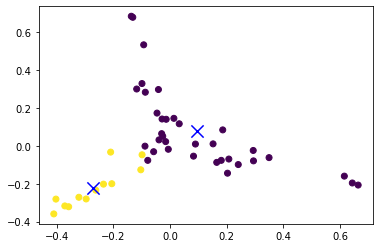

In [32]:
# уменьшаем размерность фич через PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0) # кол-во компонентов = кол-во кластеров
reduced_features = pca.fit_transform(features.toarray())

reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
plt.show()

In [33]:
# предсказания кластеров
pred = cls.predict(features)
# подцепляем предсказания к датасету
df_ru['cluster_prediction'] = pred
df_ru

,Unnamed: 0,domain,text,language,processed_text,travel_words_count,cluster_prediction
56,56,parcedsites/mainpages/a9/cb/a9/a9cba9f59d22ccf...,Жд билеты на поезд через Интернет: за...,ru,жд билет поезд интернет забронировать билет он...,49,0
57,57,parcedsites/mainpages/87/ef/aa/87efaa6dad16922...,Бронирование отелей и гостини...,ru,бронирование отелей гостиница скидкой hotelloo...,80,0
74,74,parcedsites/mainpages/4a/79/16/4a7916358566d37...,...,ru,планета спорт спортивный интернет качественный...,30,1
127,127,parcedsites/mainpages/7c/54/95/7c54950208b4e3b...,...,ru,билет автобус поезд самолёт поиск omio поездап...,35,0
160,160,parcedsites/mainpages/b1/7a/64/b17a646e2607471...,Билеты в театры Москвы. Купи...,ru,билет театр москва электронный билет театр лег...,10,0
191,191,parcedsites/mainpages/03/af/6f/03af6f06b778820...,"Дешевые авиабилеты онлайн, купить авиаб...",ru,дешёвый авиабилет онлаин авиабилет дёшево bile...,31,0
282,282,parcedsites/mainpages/ec/ee/9d/ecee9dacc216618...,Спортмастер — спортивный магазин для в...,ru,спортмастер спортивный всей семья поддержка ва...,19,1
302,302,parcedsites/mainpages/9f/09/30/9f0930423ed2cc3...,Настоящий маркетплейс goods.ru - место выгодны...,ru,настоящие маркетплеис goods ru место выгодный ...,18,1
306,306,parcedsites/mainpages/46/8b/fc/468bfc858fa390e...,"Путевки в Турцию, Грецию, Египет, Белару...",ru,путёвка турция греция египет беларусь кипр оаэ...,162,0
334,334,parcedsites/mainpages/2a/e3/0a/2ae30ad20f0dc7d...,Интернет магазин подарков - купить ори...,ru,интернет подарок оригинальный необычный подаро...,15,1


In [35]:
# похоже что кластер 0 относится к тревелу (по большей части)
df_ru[df_ru['cluster_prediction'] == 0]

,Unnamed: 0,domain,text,language,processed_text,travel_words_count,cluster_prediction
56,56,parcedsites/mainpages/a9/cb/a9/a9cba9f59d22ccf...,Жд билеты на поезд через Интернет: за...,ru,жд билет поезд интернет забронировать билет он...,49,0
57,57,parcedsites/mainpages/87/ef/aa/87efaa6dad16922...,Бронирование отелей и гостини...,ru,бронирование отелей гостиница скидкой hotelloo...,80,0
127,127,parcedsites/mainpages/7c/54/95/7c54950208b4e3b...,...,ru,билет автобус поезд самолёт поиск omio поездап...,35,0
160,160,parcedsites/mainpages/b1/7a/64/b17a646e2607471...,Билеты в театры Москвы. Купи...,ru,билет театр москва электронный билет театр лег...,10,0
191,191,parcedsites/mainpages/03/af/6f/03af6f06b778820...,"Дешевые авиабилеты онлайн, купить авиаб...",ru,дешёвый авиабилет онлаин авиабилет дёшево bile...,31,0
306,306,parcedsites/mainpages/46/8b/fc/468bfc858fa390e...,"Путевки в Турцию, Грецию, Египет, Белару...",ru,путёвка турция греция египет беларусь кипр оаэ...,162,0
381,381,parcedsites/mainpages/0e/a1/a7/0ea1a769d49ff34...,Нужна онлайн-виза: Шенген...,ru,нужный онлаин виза шенген проблема оформить кл...,46,0
384,384,parcedsites/mainpages/2a/4d/b6/2a4db6a16bbc0fa...,ПАО СК «Росгосстрах» — флагман отечес...,ru,пао ск росгосстрах флагман отечественный рынок...,10,0
445,445,parcedsites/mainpages/5c/65/08/5c65086e800d3e2...,"ᐉ Купить тур онлайн с вылетом из Киева, Украин...",ru,тур онлаин вылет киев украина farvater возвращ...,40,0
452,452,parcedsites/mainpages/12/5f/e7/125fe7b87218490...,OZON.travel - бронирование билетов на самолет ...,ru,ozon travel бронирование билет самолёт билетов...,16,0
